<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">


# Modpath

This notebook shows how to create a particle tracking model using modpath.

### Contents<a name="TOC"></a>
1. [Groundwater Flow Model](#model)
2. [Modpath](#modpath)

In [1]:
import os
import sys
import nlmod
import flopy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import logging

In [2]:
print(f'nlmod version: {nlmod.__version__}')

# toon informatie bij het aanroepen van functies
logging.basicConfig(level=logging.INFO)

nlmod version: 0.2.5b


### [1. Groundwater Flow Model](#TOC)<a name="model"></a>

We use the groundwater flow model from the [03_local_grid_refinement notebook](03_local_grid_refinement). Make sure to run this notebook before you run this notebook

In [3]:
# load lgr model dataset
model_ws = 'model3'
model_name = 'IJm_planeten'

model_ds = xr.open_dataset(os.path.join(model_ws, "cache", "full_model_ds.nc"))

In [4]:
# load lgr simulation and groundwateflow model
# set exe_name to point to mf6 version in nlmod bin directory
exe_name = os.path.join(os.path.dirname(nlmod.__file__),
                        'bin', 'mf6')
if sys.platform.startswith('win'):
    exe_name += ".exe"
    
sim = flopy.mf6.MFSimulation.load("mfsim.nam", sim_ws=model_ws, exe_name=exe_name)
gwf = sim.get_model(model_name=model_name)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package npf...
    loading package ic...
    loading package oc...
    loading package ghb...
    loading package drn...
    loading package chd...
    loading package rch...
  loading ims package ijm_planeten...


### [2. Modpath](#TOC)<a name="modpath"></a>



In [5]:
# list with xy coordinates to start particle tracking from 
xy_start = [(101500, 496500), (101500,499100)]

# create a modpath model
mpf = nlmod.mfpackages.modpath.mpf(gwf)

# create the basic modpath package
_mpfbas = nlmod.mfpackages.modpath.bas(mpf)

# find the nodes for given xy
nodes = nlmod.mfpackages.modpath.xy_to_nodes(xy_start, mpf, model_ds, layer=5)

# create a particle tracking group at the cell faces
pg = nlmod.mfpackages.modpath.pg_from_fdt(nodes)

# create the modpath simulation file
mpsim = nlmod.mfpackages.modpath.sim(mpf, pg, gwf)

INFO:nlmod.mfpackages.modpath:particle group with 9 particle per cell face, 54 particles per cell


adding Package:  MPBAS
adding Package:  MPSIM


In [6]:
# remove previous output
nlmod.mfpackages.modpath.remove_output(mpf)

# write modpath datasets
mpf.write_input()

# run modpath
mpf.run_model()

could not find 'mp7_ijm_planeten_f.mppth'
could not find 'mp7_ijm_planeten_f.timeseries'
could not find 'mp7_ijm_planeten_f.mpend'

Writing packages:
   Package:  MPBAS
   Package:  MPSIM
 
FloPy is using the following  executable to run the model: c:\users\oebbe\02_python\nlmod\nlmod\mfpackages\..\bin\mp7.exe

MODPATH Version 7.2.002 PROVISIONAL 
Program compiled Nov 23 2021 09:33:21 with IFORT compiler (ver. 19.0.5)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     6.  Time =  3.65700E+03  Steady-state flow                                                    
Processing Time Step     1 Period     5.  Time =  3.65600E+03  Steady-state flow                                                    
Processing Time Step     1 Period     4.  Time =  3.65500E+03  Steady-state flow                                                    
Processing Time Step     1 Period     3.  Time =  3.65400E+03  Steady-state flow                                                 

(True, [])

In [7]:
pdata = nlmod.mfpackages.modpath.load_pathline_data(mpf)

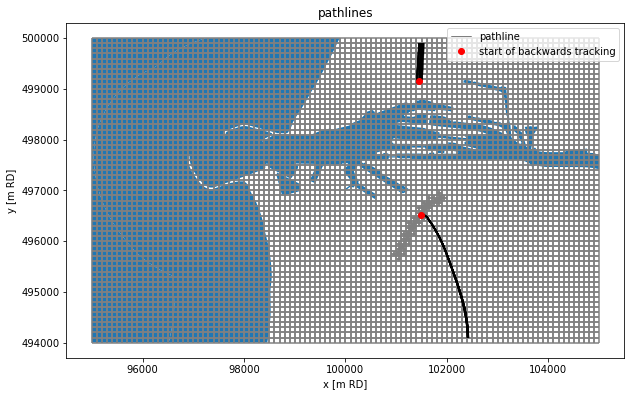

In [8]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.set_aspect("equal")
ax = nlmod.visualise.plots.plot_modelgrid(model_ds, gwf, ax=ax)

for pid in np.unique(pdata['particleid']):
    pf = pdata[pdata['particleid']==pid]
    ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5)
ax.plot(pf['x'],pf['y'], color="k", linewidth=0.5, label='pathline')

cids = [nlmod.mfpackages.modpath.xy_to_cid(xy, model_ds) for xy in xy_start]
ax.plot(model_ds.x[cids],model_ds.y[cids], label='start of backwards tracking', ls='', marker='o', color='red')
ax.set_title(f'pathlines')
ax.legend()